Mini-Project 1 


Base code to generate figures

Using TensorFlow backend.


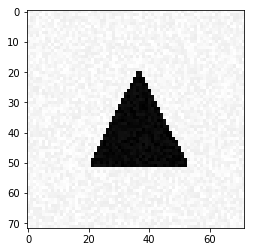

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import to_categorical


# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


3 - Simple Classification

First, we generate a training set of 300 images of three geometric shapes (rectangle, disk, triangle)

In [2]:
[X_train, Y_train] = generate_dataset_classification(300, 20)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Then we can build 2 linear classifiers : Stochastic Gradient Descent (SGD) and Adam.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten,Convolution2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from keras.utils import to_categorical

encoder=LabelEncoder()
encoder.fit(Y_train)
encoded_Y=encoder.transform(Y_train)

def create_baseline_adam():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=5184))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model
def create_baseline_SGD():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=5184))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

    return model






ValueError: bad input shape (300, 6)

We can now test the two models.

In [4]:
model=create_baseline_SGD()
labels = to_categorical(Y_train, num_classes=3)
model.fit(X_train, labels,epochs=50, batch_size=32)


X_test= generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

Epoch 1/50
300/300 [==============================] - 2s 7ms/step - loss: 1.2466 - acc: 0.3567
Epoch 2/50
300/300 [==============================] - 0s 329us/step - loss: 1.0811 - acc: 0.3767
Epoch 3/50
300/300 [==============================] - 0s 336us/step - loss: 1.0122 - acc: 0.5600
Epoch 4/50
300/300 [==============================] - 0s 364us/step - loss: 0.9199 - acc: 0.5767
Epoch 5/50
300/300 [==============================] - 0s 347us/step - loss: 0.8391 - acc: 0.6467
Epoch 6/50
300/300 [==============================] - 0s 329us/step - loss: 0.7714 - acc: 0.6700
Epoch 7/50
300/300 [==============================] - 0s 359us/step - loss: 0.8149 - acc: 0.6100
Epoch 8/50
300/300 [==============================] - 0s 331us/step - loss: 0.7191 - acc: 0.6700
Epoch 9/50
300/300 [==============================] - 0s 352us/step - loss: 0.6089 - acc: 0.7433
Epoch 10/50
300/300 [==============================] - 0s 382us/step - loss: 0.5480 - acc: 0.7767
Epoch 11/50
300/300 [==========

array([[0., 1., 0.]], dtype=float32)

In [5]:
model=create_baseline_adam()
labels = to_categorical(Y_train, num_classes=3)
model.fit(X_train, labels,epochs=50, batch_size=32)


X_test= generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

Epoch 1/50
300/300 [==============================] - 1s 2ms/step - loss: 1.7024 - acc: 0.4233
Epoch 2/50
300/300 [==============================] - 0s 482us/step - loss: 1.0810 - acc: 0.4967
Epoch 3/50
300/300 [==============================] - 0s 456us/step - loss: 0.9901 - acc: 0.5933
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.9074 - acc: 0.598 - 0s 445us/step - loss: 0.9096 - acc: 0.6100
Epoch 5/50
300/300 [==============================] - 0s 426us/step - loss: 0.8504 - acc: 0.6733
Epoch 6/50
300/300 [==============================] - 0s 425us/step - loss: 0.7752 - acc: 0.7267
Epoch 7/50
300/300 [==============================] - 0s 462us/step - loss: 0.7263 - acc: 0.7300
Epoch 8/50
300/300 [==============================] - 0s 507us/step - loss: 0.6743 - acc: 0.7967
Epoch 9/50
300/300 [==============================] - 0s 451us/step - loss: 0.6376 - acc: 0.8033
Epoch 10/50
300/300 [==============================] - 0s 409us/step - loss: 0.5852 - acc: 

array([[0., 1., 0.]], dtype=float32)

First we observe that the Adam optimizer has a higher lever of complexity (computing time) but the loss is very low in comparison with SGD optimizer.
We can conclude after several tests that the two classifiers seems to be relevant, because they predict successfully the right shape.

4 Visualization of the Solution

We keep the Adam optimizer and we want to visualize the weights of this classifier as images.

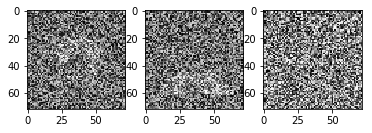

In [6]:
column1=model.get_weights()[0][:,0]
column2=model.get_weights()[0][:,1]
column3=model.get_weights()[0][:,2]

IMAGE_SIZE = 72
plt.subplot(1,3,1)
plt.imshow(column1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(column2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(column3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We visualize the three columns and we note that it is very hard to distinguish the three shapes.


5 A More Difficult Classification problem

We train our Adam classifier on a training set of 300 images with geometric shapes (which have now a free location)


In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

model=create_baseline_adam()
labels = to_categorical(Y_train, num_classes=3)
model.fit(X_train, labels,epochs=50, batch_size=32)




Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/50
300/300 [==============================] - 1s 2ms/step - loss: 2.2159 - acc: 0.3433
Epoch 2/50
300/300 [==============================] - 0s 693us/step - loss: 1.1704 - acc: 0.3233
Epoch 3/50
300/300 [==============================] - 0s 613us/step - loss: 1.1431 - acc: 0.3667
Epoch 4/50
300/300 [==============================] - 0s 633us/step - loss: 1.1534 - acc: 0.3733
Epoch 5/50
300/300 [==============================] - 0s 733us/step - loss: 1.0651 - acc: 0.4167
Epoch 6/50
300/300 [==============================] - 0s 520us/step - loss: 1.0476 - acc: 0.4333
Epoch 7/50
300/300 [==============================] - 0s 533us/step - loss: 1.0717 - acc: 0.3600
Epoch 8/50
300/300 [==============================] - 0s 653us/step - loss: 1.0722 - acc: 0.4033
Epoch 9/50
300/300 [==============================] - 0s 540us/step - loss: 1.0517 - acc: 0.4067
Epoch

Now we test it on a test set.

In [8]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 1ms/step


[0.8585142962137858, 0.5633333333333334]

So the loss is 0.86 and the accuracy is 0.56.

The result is disappointing and we can conclude that this classifier is not adequate anymore. 

In order to improve these results, we can build a convolutional network.
There are 1 convolutional layer with 16 5x5 filters, 1 pooling layer and one fully connected layer.

In [11]:
def create_baseline_conv():
    model = Sequential()
    
    model.add(Convolution2D(16, (5, 5), activation='relu', input_shape=(72,72,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    
    model.add(Flatten())
    
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model=create_baseline_conv()
labels = to_categorical(Y_train, num_classes=3)

test = X_train.reshape(X_train.shape[0], 72, 72 , 1)

model.fit(test, labels,epochs=50, batch_size=32)




Epoch 1/50
300/300 [==============================] - 2s 8ms/step - loss: 1.0849 - acc: 0.3900A: 0s - loss: 1.1046 - acc: 0.3
Epoch 2/50
300/300 [==============================] - 2s 6ms/step - loss: 0.8989 - acc: 0.6600
Epoch 3/50
300/300 [==============================] - 2s 6ms/step - loss: 0.7575 - acc: 0.7700
Epoch 4/50
300/300 [==============================] - 2s 6ms/step - loss: 0.6468 - acc: 0.7667
Epoch 5/50
300/300 [==============================] - 2s 6ms/step - loss: 0.5763 - acc: 0.8100
Epoch 6/50
300/300 [==============================] - 2s 7ms/step - loss: 0.4860 - acc: 0.8800
Epoch 7/50
300/300 [==============================] - 2s 6ms/step - loss: 0.4922 - acc: 0.8467
Epoch 8/50
300/300 [==============================] - 2s 7ms/step - loss: 0.4149 - acc: 0.8667
Epoch 9/50
300/300 [==============================] - 2s 6ms/step - loss: 0.3682 - acc: 0.9167
Epoch 10/50
300/300 [==============================] - 2s 7ms/step - loss: 0.3341 - acc: 0.9400
Epoch 11/50
300/30

The computional time is higher than previous classifiers because the model is more complex. 

In [12]:
[X_test, Y_test] = generate_test_set_classification()
test2=X_test.reshape(X_test.shape[0], 72, 72 , 1)
model.evaluate(test2, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 1s 4ms/step


[0.8005096546808879, 0.7399999992052714]

The loss is 0.8 and has decreased somewhat. And the accuracy is 0.74 and has raised.

6 A regression problem

We want now to predict the images locations of the vertices of a triangle.

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


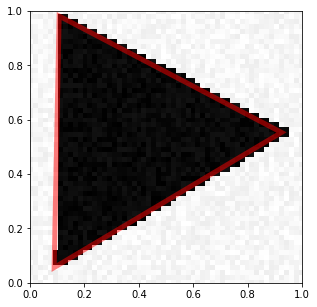

In [2]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

Y_train[i] is composed of coordinates of the 3 vertices : U[0], V[0], U[1], V[1], U[2], V[2]

So we build and train a regressor on this data.

First, I try to use the Sklearn linear regression.

In [3]:
from sklearn import linear_model
from sklearn.preprocessing import normalize

regr = linear_model.LinearRegression()

Y_train_n=normalize(Y_train,norm='l1')

regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [ ]:
[X_test, Y_test] = generate_test_set_regression()

Y_pred=regr.predict(X_test)
visualize_prediction(X_test[2], Y_pred[2])

The results are pretty bad because the predict vertices don't match with the real ones.

So now I try with a keras regressor.

In [16]:
from keras.layers import Activation
def baseline_model_regression():
    model = Sequential()
    
    model.add(Convolution2D(16, (5, 5), activation='relu', input_shape=(72,72,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    
    model.add(Flatten())
    
    model.add(Dense(6, activation='linear')) #here the linear regression activation
    model.compile(loss='mean_squared_error',optimizer='SGD', metrics=['accuracy'])

    return model


#Use the model
regr = baseline_model_regression()
#Y_train_n=normalize(Y_train)
train2=X_train.reshape(X_train.shape[0], 72, 72 , 1)
regr.fit(train2, Y_train_n,epochs =100,batch_size = 32)

Epoch 1/100
300/300 [==============================] - 4s 15ms/step - loss: 0.0871 - acc: 0.1733
Epoch 2/100
300/300 [==============================] - 2s 7ms/step - loss: 0.0444 - acc: 0.1900
Epoch 3/100
300/300 [==============================] - 2s 7ms/step - loss: 0.0450 - acc: 0.1500
Epoch 4/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0430 - acc: 0.1733
Epoch 5/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0423 - acc: 0.1800
Epoch 6/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0418 - acc: 0.2200
Epoch 7/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0410 - acc: 0.2200
Epoch 8/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0408 - acc: 0.2400
Epoch 9/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0398 - acc: 0.2267
Epoch 10/100
300/300 [==============================] - 2s 6ms/step - loss: 0.0395 - acc: 0.2333
Epoch 11/100
300/300 [================

Even with 100 epochs, the accuracy remains low (around 45%) on the train data. 

In [17]:
[X_test, Y_test] = generate_test_set_regression()

test2=X_test.reshape(X_test.shape[0], 72, 72 , 1)
Y_pred=regr.predict(test2)



Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


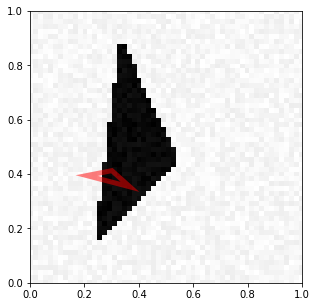

In [18]:
visualize_prediction(X_test[2], Y_pred[2])

7 - Image Denoising

We modify some generating functions to generate pairs of images, with and without noise.
We limit the noise for now.


In [110]:
random_noise=(72*72)*np.random.random()

def generate_a_drawing_noise(figsize, U, V, noise=random_noise):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata1 = imdata + noise * np.random.random(imdata.size)
    
    plt.close(fig)
    return imdata,imdata1

def generate_a_rectangle_noise(noise=random_noise, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_noise(figsize, U, V, noise)


def generate_a_disk_noise(noise=random_noise, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_noise(figsize, U, V, noise)

def generate_a_triangle_noise(noise=random_noise, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata1,imdata2 = generate_a_drawing_noise(figsize, U, V, noise)
    return [imdata1,imdata2, [U[0], V[0], U[1], V[1], U[2], V[2]]]



We can display the pairs of image with the following code

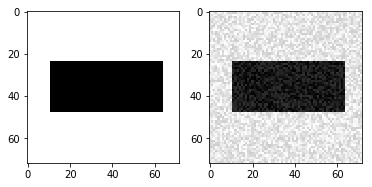

In [111]:
im1,im2 = generate_a_rectangle_noise(random_noise, True)
plt.subplot(1,2,1)
plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

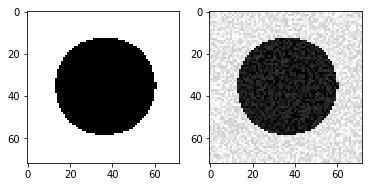

In [112]:
im1,im2 = generate_a_disk_noise(random_noise)
plt.subplot(1,2,1)
plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

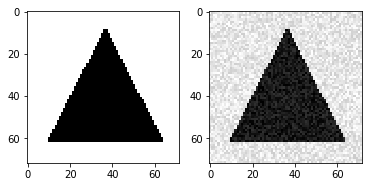

In [113]:
[im1,im2, v] = generate_a_triangle_noise(random_noise, False)
plt.subplot(1,2,1)
plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(im2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

I did not succeed in building the hourglass network.